# Loading and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
raw_data_dir = img_dir = "/content/drive/MyDrive/data_notebooks/archive"

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Statistics

In [4]:
import re
import pandas as pd
import os

# Reload the original combined dataset
csv_files = [f for f in os.listdir(raw_data_dir) if f.endswith('.csv')]
combined_df = pd.concat([pd.read_csv(os.path.join(raw_data_dir, file)) for file in csv_files], ignore_index=True)

def extract_marker(element):
    # Add type checking and conversion
    if pd.isna(element):  # Check for NaN values
        return None

    element = str(element)  # Convert to string explicitly
    marker_pattern = r'/Marker/(\d+)'
    match = re.search(marker_pattern, element)
    if match:
        return int(match.group(1))
    else:
        return None

# Create a new 'Marker' column by extracting the marker information
combined_df['Marker'] = combined_df['Elements'].apply(extract_marker)

# Inspect the marker distribution
print("\nMarker distribution:")
print(combined_df['Marker'].value_counts())

# Proceed with the Bayesian analysis using the extracted marker information

<ipython-input-4-2ea41f3ce313>:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(os.path.join(raw_data_dir, file)) for file in csv_files], ignore_index=True)
<ipython-input-4-2ea41f3ce313>:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(os.path.join(raw_data_dir, file)) for file in csv_files], ignore_index=True)
<ipython-input-4-2ea41f3ce313>:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(os.path.join(raw_data_dir, file)) for file in csv_files], ignore_index=True)
<ipython-input-4-2ea41f3ce313>:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(os.path.join(raw_data_dir, file)) for file in csv_files], ignore_index=Tr


Marker distribution:
Marker
3.0    112
2.0     70
1.0     67
4.0      1
Name: count, dtype: int64


In [5]:
!pip install --upgrade pymc arviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.9/501.9 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: pymc
    Found existing installation: pymc 5.18.2
    Uninstalling pymc-5.18.2:
      Successfully uninstalled pymc-5.18.2


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import arviz as az

# Load data
df = pd.read_csv("/content/drive/MyDrive/data_notebooks/20241127_brainwaves.csv")

# Use PCA components for clustering
features = ['Delta_PCA', 'Theta_PCA', 'Alpha_PCA', 'Beta_PCA', 'Gamma_PCA']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering
print("Performing K-means clustering...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Marker'] = kmeans.fit_predict(X_scaled) + 1  # Add 1 to make markers 1, 2, 3

# Sample data for analysis
sample_size = 2000
df_sample = df.sample(n=sample_size, random_state=42)

print("\nMarker distribution in sample:")
print(df_sample['Marker'].value_counts())

Performing K-means clustering...

Marker distribution in sample:
Marker
1    1161
3     714
2     125
Name: count, dtype: int64



Analyzing Delta band:


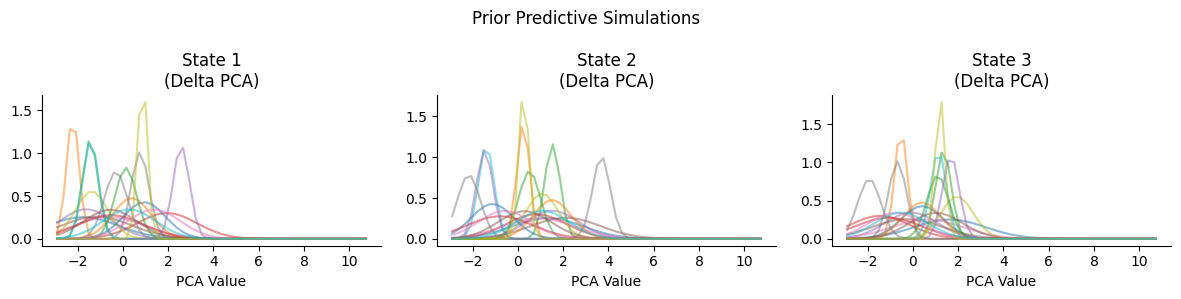

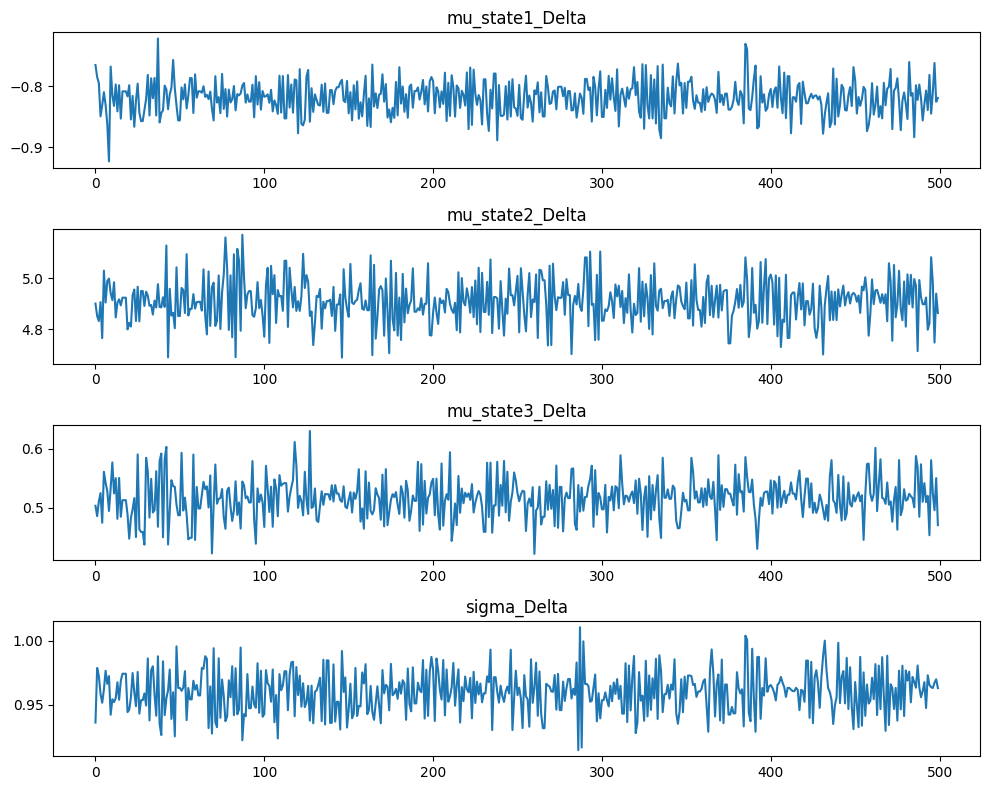


Analyzing Theta band:


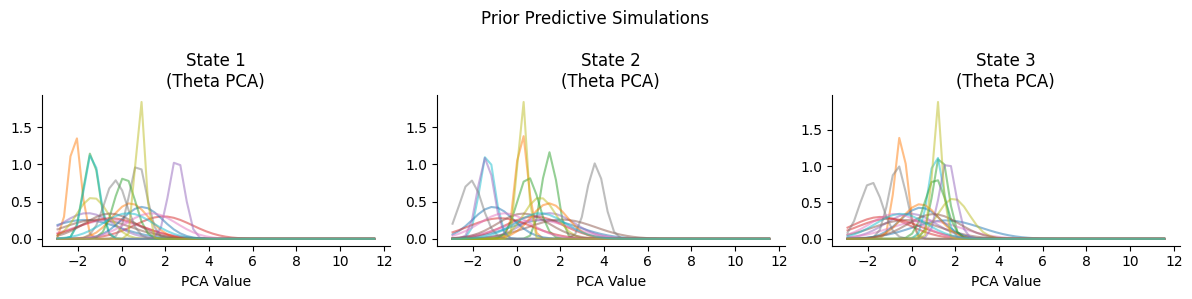

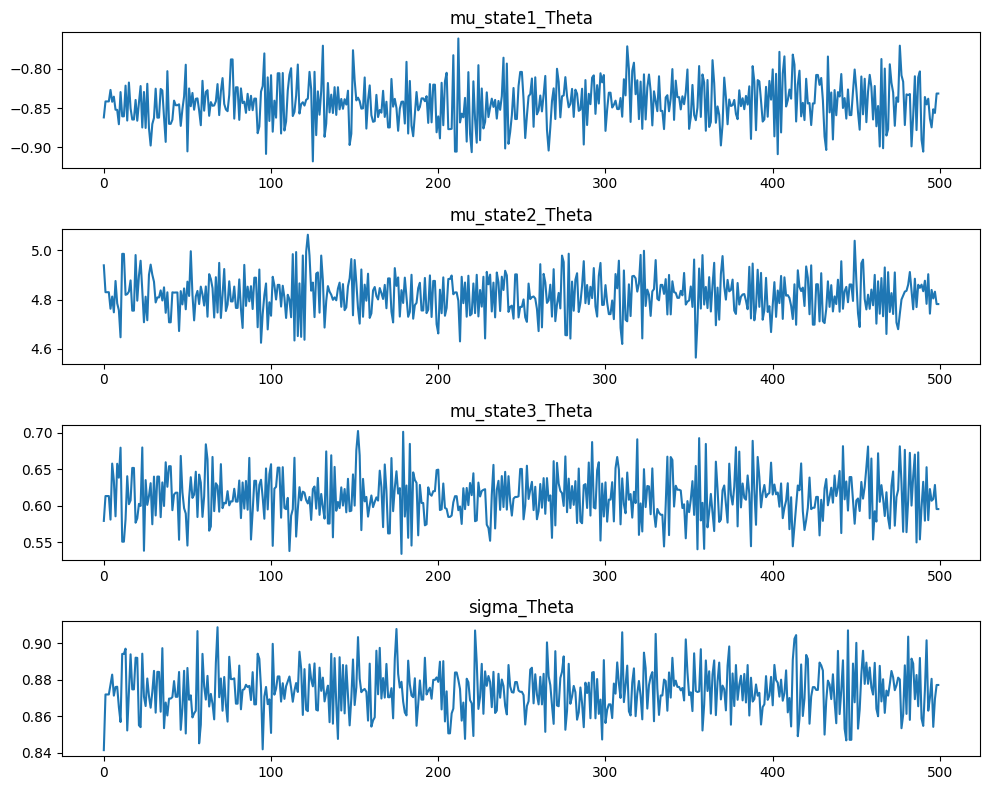


Analyzing Alpha band:


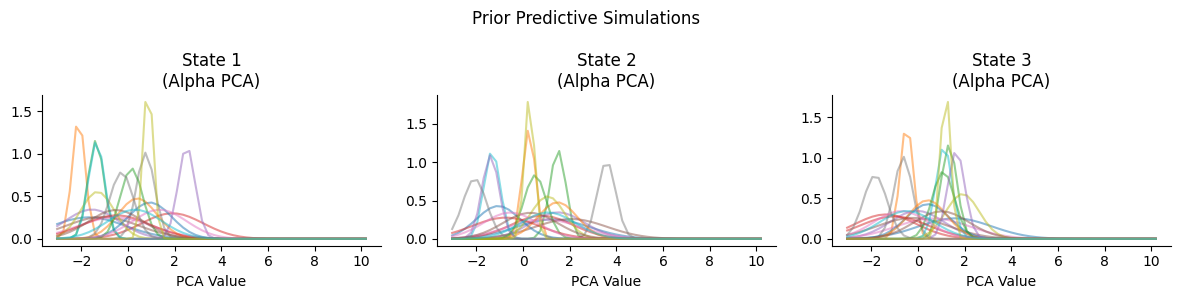

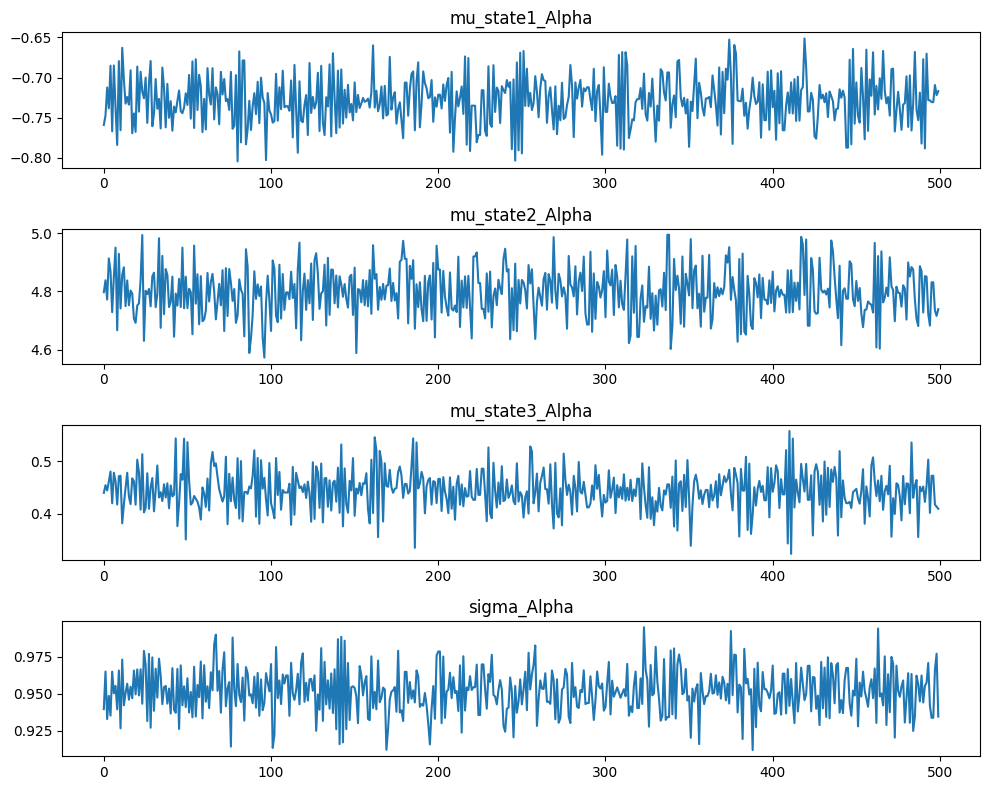


Analyzing Beta band:


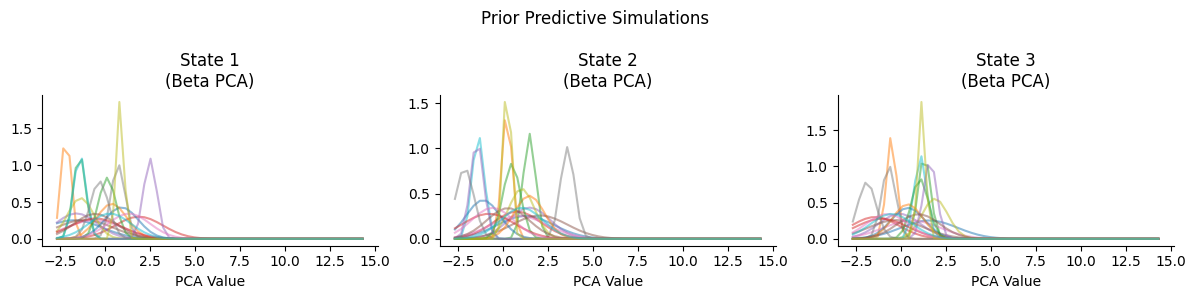

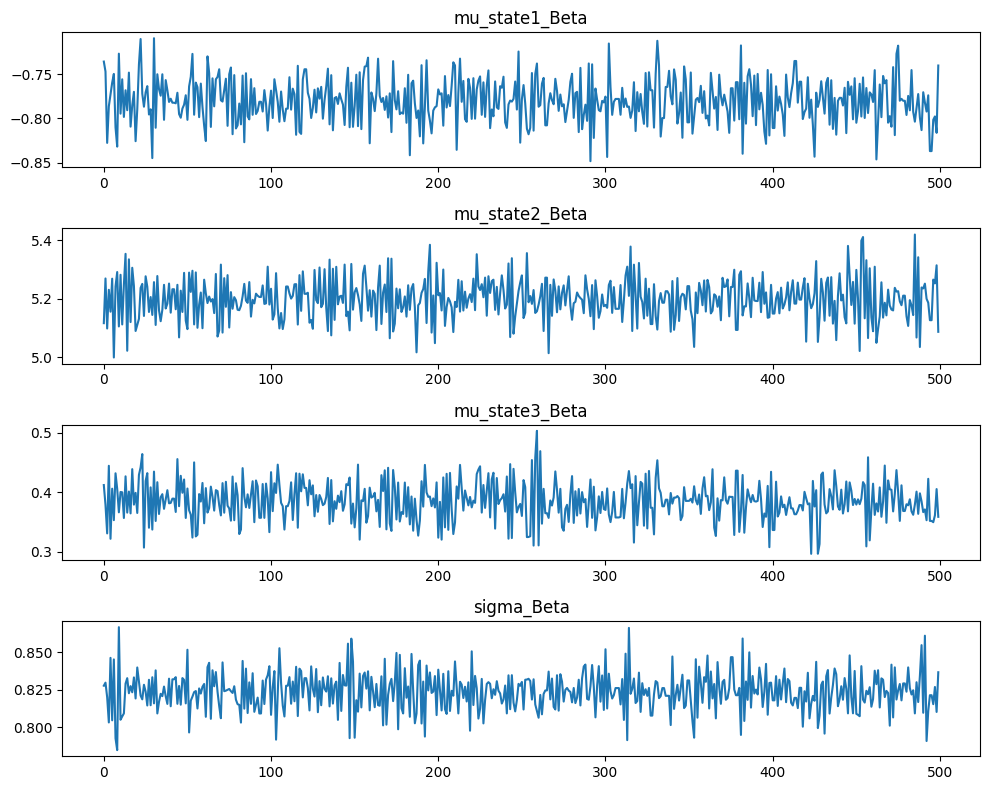


Analyzing Gamma band:


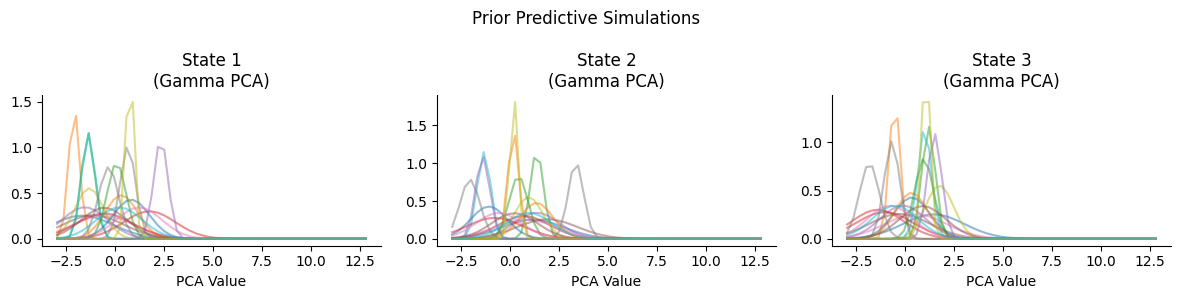

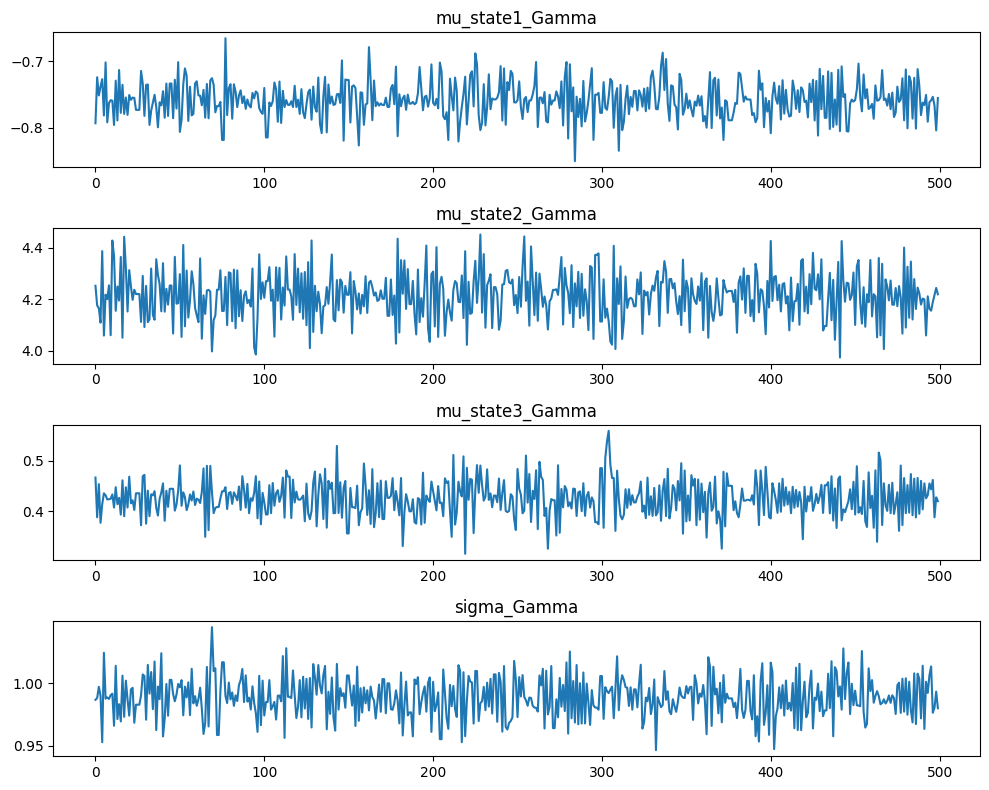

In [11]:
import gc  # Garbage collection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_prior_predictive(df_sample, band='Beta', n_iter=20):  # Reduced iterations
    """Add prior predictive simulations visualization with memory optimization"""
    band_col = f'{band}_PCA'

    # Fewer points in x_range
    x_range = np.linspace(df_sample[band_col].min(), df_sample[band_col].max(), 50)

    # Pre-allocated arrays
    state1_sims = np.zeros((n_iter, len(x_range)))
    state2_sims = np.zeros((n_iter, len(x_range)))
    state3_sims = np.zeros((n_iter, len(x_range)))

    # Get statistics once
    empirical_mean = df_sample[band_col].mean()
    empirical_std = df_sample[band_col].std()

    rng = np.random.default_rng(42)

    # Generate simulations
    for i in range(n_iter):
        sigma = rng.uniform(low=0.1, high=2)

        for j, state_sims in enumerate([state1_sims, state2_sims, state3_sims]):
            mu = rng.normal(loc=empirical_mean, scale=empirical_std)
            state_sims[i] = stats.norm(loc=mu, scale=sigma).pdf(x_range)

    # Plot with memory cleanup
    fig, axes = plt.subplots(figsize=(12, 3), ncols=3)

    # Plot states
    for i, (sims, title) in enumerate(zip(
        [state1_sims, state2_sims, state3_sims],
        [f"State {j+1}\n({band} PCA)" for j in range(3)]
    )):
        for sim in sims:
            axes[i].plot(x_range, sim, alpha=0.5)
        axes[i].set_title(title)

    [ax.set_xlabel("PCA Value") for ax in axes]

    fig.suptitle('Prior Predictive Simulations')
    plt.tight_layout()
    sns.despine()
    plt.show()
    plt.close()

    # Clear memory
    del state1_sims, state2_sims, state3_sims

def plot_trace_parameters(results, band, n_samples=500):  # Reduced samples
    """Add trace plots for model parameters with memory optimization"""
    trace = results[band]
    var_names = [f'mu_state1_{band}', f'mu_state2_{band}', f'mu_state3_{band}', f'sigma_{band}']

    # Create subplot for each parameter
    fig, axes = plt.subplots(len(var_names), 1, figsize=(10, 2*len(var_names)))

    for i, var in enumerate(var_names):
        if var in trace.posterior:
            samples = trace.posterior[var].values.flatten()[:n_samples]
            axes[i].plot(samples)
            axes[i].set_title(var)

    plt.tight_layout()
    plt.show()
    plt.close()

# Add visualizations one band at a time
for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']:
    print(f"\nAnalyzing {band} band:")
    plot_prior_predictive(df_sample, band)
    plt.close('all')  # Clear plots from memory
    plot_trace_parameters(results, band)
    plt.close('all')  # Clear plots from memory
    gc.collect()  # Force garbage collection


Sampling for Delta band...


Output()

Output()


Sampling for Theta band...


Output()

Output()


Sampling for Alpha band...


Output()

Output()


Sampling for Beta band...


Output()

Output()


Sampling for Gamma band...


Output()

Output()

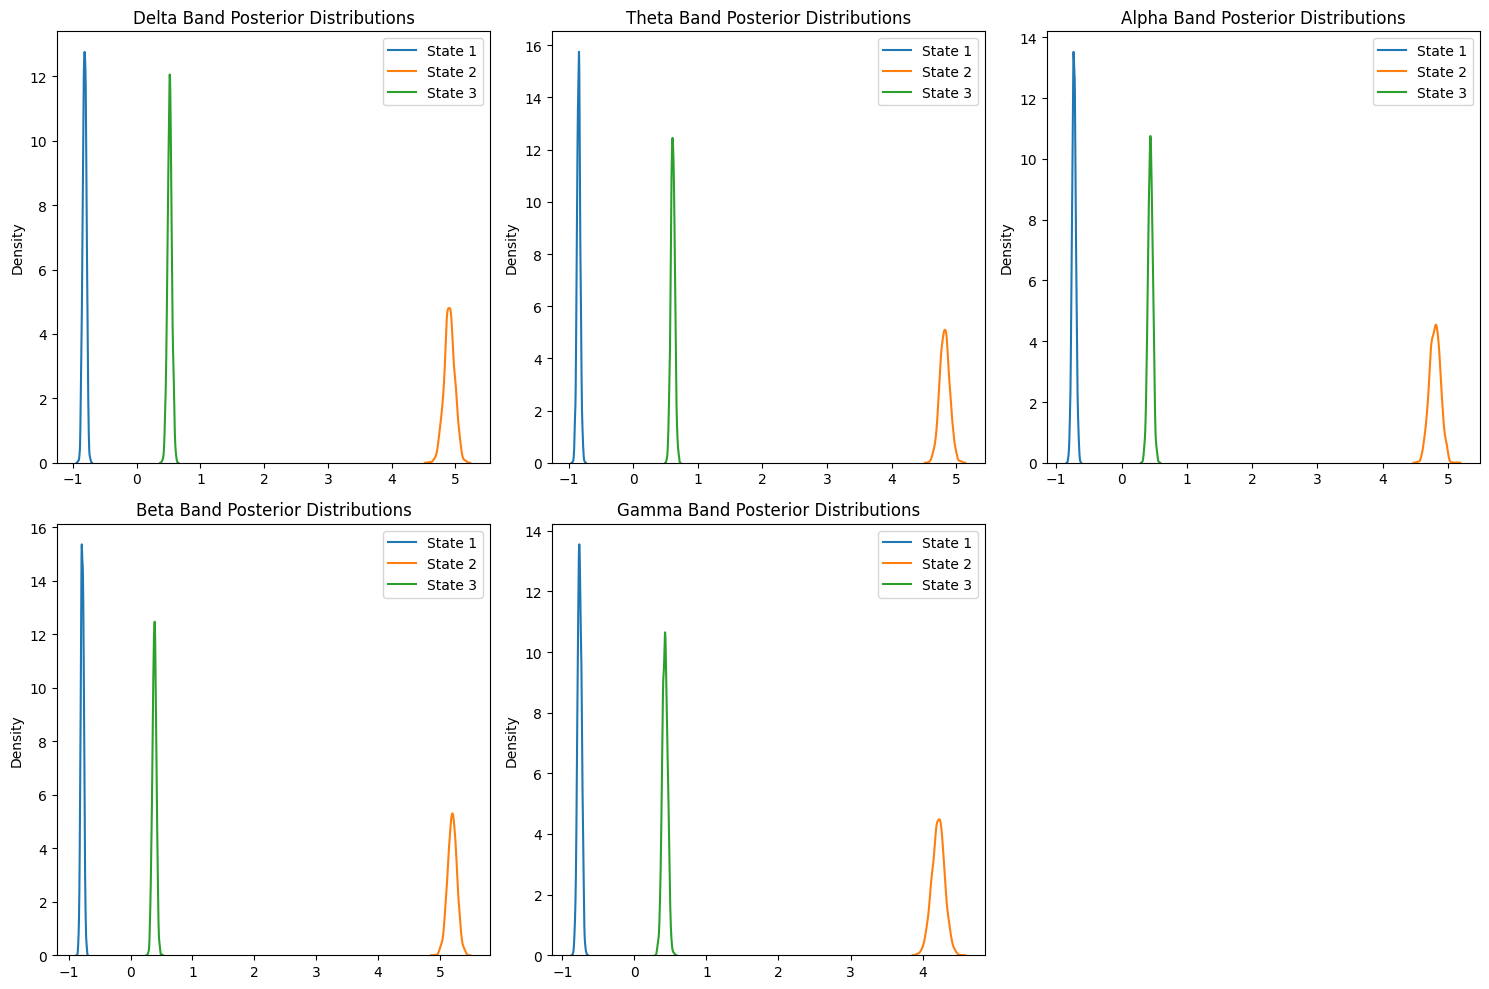

Bayesian Analysis Summary


Delta Band Analysis:
------------------------------

State 1:
  Mean: -0.819
  Std Dev: 0.029
  95% HDI: [-0.876, -0.765]

State 2:
  Mean: 4.908
  Std Dev: 0.084
  95% HDI: [4.741, 5.070]

State 3:
  Mean: 0.518
  Std Dev: 0.035
  95% HDI: [0.448, 0.586]

Theta Band Analysis:
------------------------------

State 1:
  Mean: -0.844
  Std Dev: 0.026
  95% HDI: [-0.897, -0.790]

State 2:
  Mean: 4.819
  Std Dev: 0.077
  95% HDI: [4.669, 4.975]

State 3:
  Mean: 0.613
  Std Dev: 0.031
  95% HDI: [0.553, 0.676]

Alpha Band Analysis:
------------------------------

State 1:
  Mean: -0.728
  Std Dev: 0.029
  95% HDI: [-0.784, -0.670]

State 2:
  Mean: 4.801
  Std Dev: 0.083
  95% HDI: [4.639, 4.966]

State 3:
  Mean: 0.443
  Std Dev: 0.037
  95% HDI: [0.371, 0.513]

Beta Band Analysis:
------------------------------

State 1:
  Mean: -0.779
  Std Dev: 0.024
  95% HDI: [-0.826, -0.732]

State 2:
  Mean: 5.199
  Std Dev: 0.075
  95% HDI: [5.048, 5.344]

State 3:
  M

In [7]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def bayesian_band_analysis(df, band):
    """
    Perform Bayesian analysis on a specific brain wave band across states
    """
    pca_col = f'{band}_PCA'

    with pm.Model() as model:
        # Priors
        mu_state1 = pm.Normal(f'mu_state1_{band}', mu=0, sigma=1)
        mu_state2 = pm.Normal(f'mu_state2_{band}', mu=0, sigma=1)
        mu_state3 = pm.Normal(f'mu_state3_{band}', mu=0, sigma=1)

        sigma = pm.HalfNormal(f'sigma_{band}', sigma=1)

        # Likelihood
        state1_data = df[df['Marker'] == 1][pca_col].values
        state2_data = df[df['Marker'] == 2][pca_col].values
        state3_data = df[df['Marker'] == 3][pca_col].values

        likelihood_state1 = pm.Normal(f'likelihood_state1_{band}',
                                    mu=mu_state1,
                                    sigma=sigma,
                                    observed=state1_data)

        likelihood_state2 = pm.Normal(f'likelihood_state2_{band}',
                                    mu=mu_state2,
                                    sigma=sigma,
                                    observed=state2_data)

        likelihood_state3 = pm.Normal(f'likelihood_state3_{band}',
                                    mu=mu_state3,
                                    sigma=sigma,
                                    observed=state3_data)

        # Sampling
        print(f"\nSampling for {band} band...")
        trace = pm.sample(1000, chains=2)

    return trace

def plot_posterior_distributions(results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, (band, trace) in enumerate(results.items()):
        if i < 5:  # We only have 5 bands
            ax = axes[i]

            # Extract samples for each state
            state1_samples = trace.posterior[f'mu_state1_{band}'].values.flatten()
            state2_samples = trace.posterior[f'mu_state2_{band}'].values.flatten()
            state3_samples = trace.posterior[f'mu_state3_{band}'].values.flatten()

            # Plot distributions
            sns.kdeplot(data=state1_samples, label='State 1', ax=ax)
            sns.kdeplot(data=state2_samples, label='State 2', ax=ax)
            sns.kdeplot(data=state3_samples, label='State 3', ax=ax)

            ax.set_title(f'{band} Band Posterior Distributions')
            ax.legend()

    # Remove the empty subplot
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

def summarize_results(results):
    summary_text = "Bayesian Analysis Summary\n"
    summary_text += "=" * 60 + "\n\n"

    for band, trace in results.items():
        summary_text += f"\n{band} Band Analysis:\n"
        summary_text += "-" * 30 + "\n"

        for state in [1, 2, 3]:
            samples = trace.posterior[f'mu_state{state}_{band}'].values.flatten()

            mean = np.mean(samples)
            std = np.std(samples)
            hdi = np.percentile(samples, [2.5, 97.5])

            summary_text += f"\nState {state}:\n"
            summary_text += f"  Mean: {mean:.3f}\n"
            summary_text += f"  Std Dev: {std:.3f}\n"
            summary_text += f"  95% HDI: [{hdi[0]:.3f}, {hdi[1]:.3f}]\n"

    print(summary_text)

# Perform analysis
results = {}
for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']:
    results[band] = bayesian_band_analysis(df_sample, band)

# Plot results
plot_posterior_distributions(results)

# Print summary
summarize_results(results)

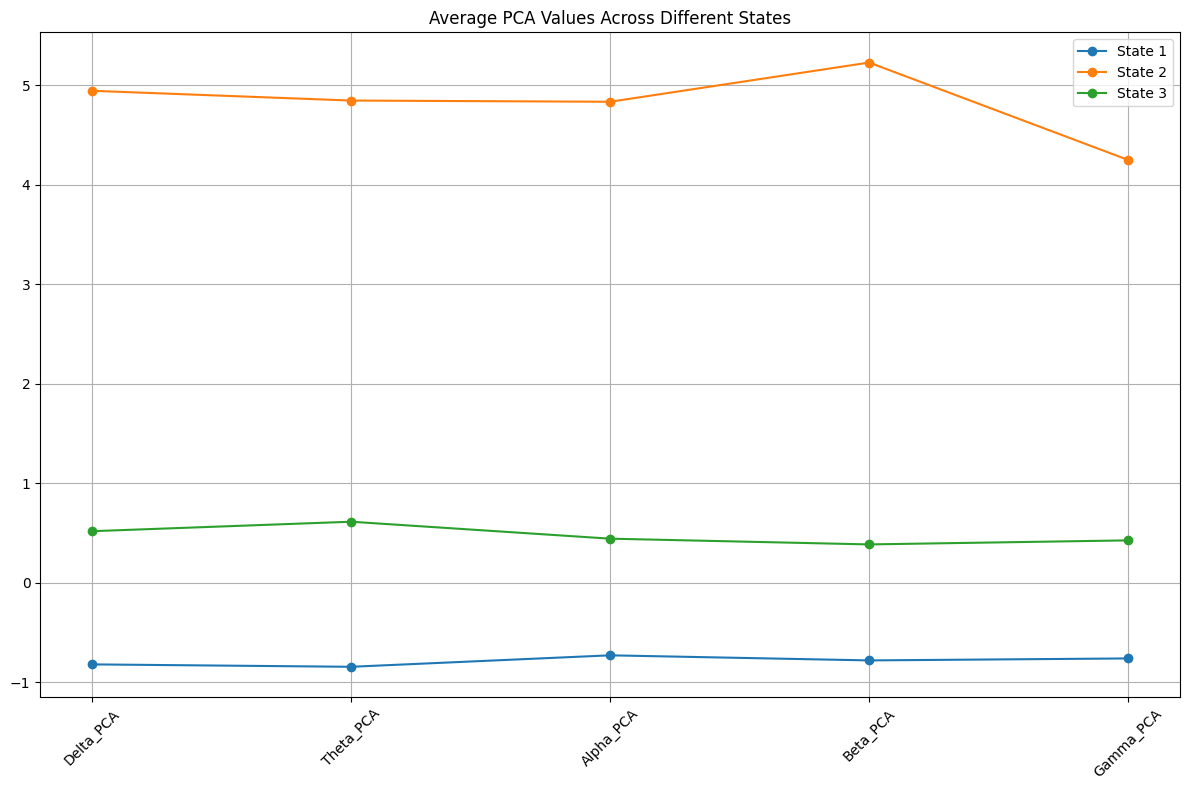

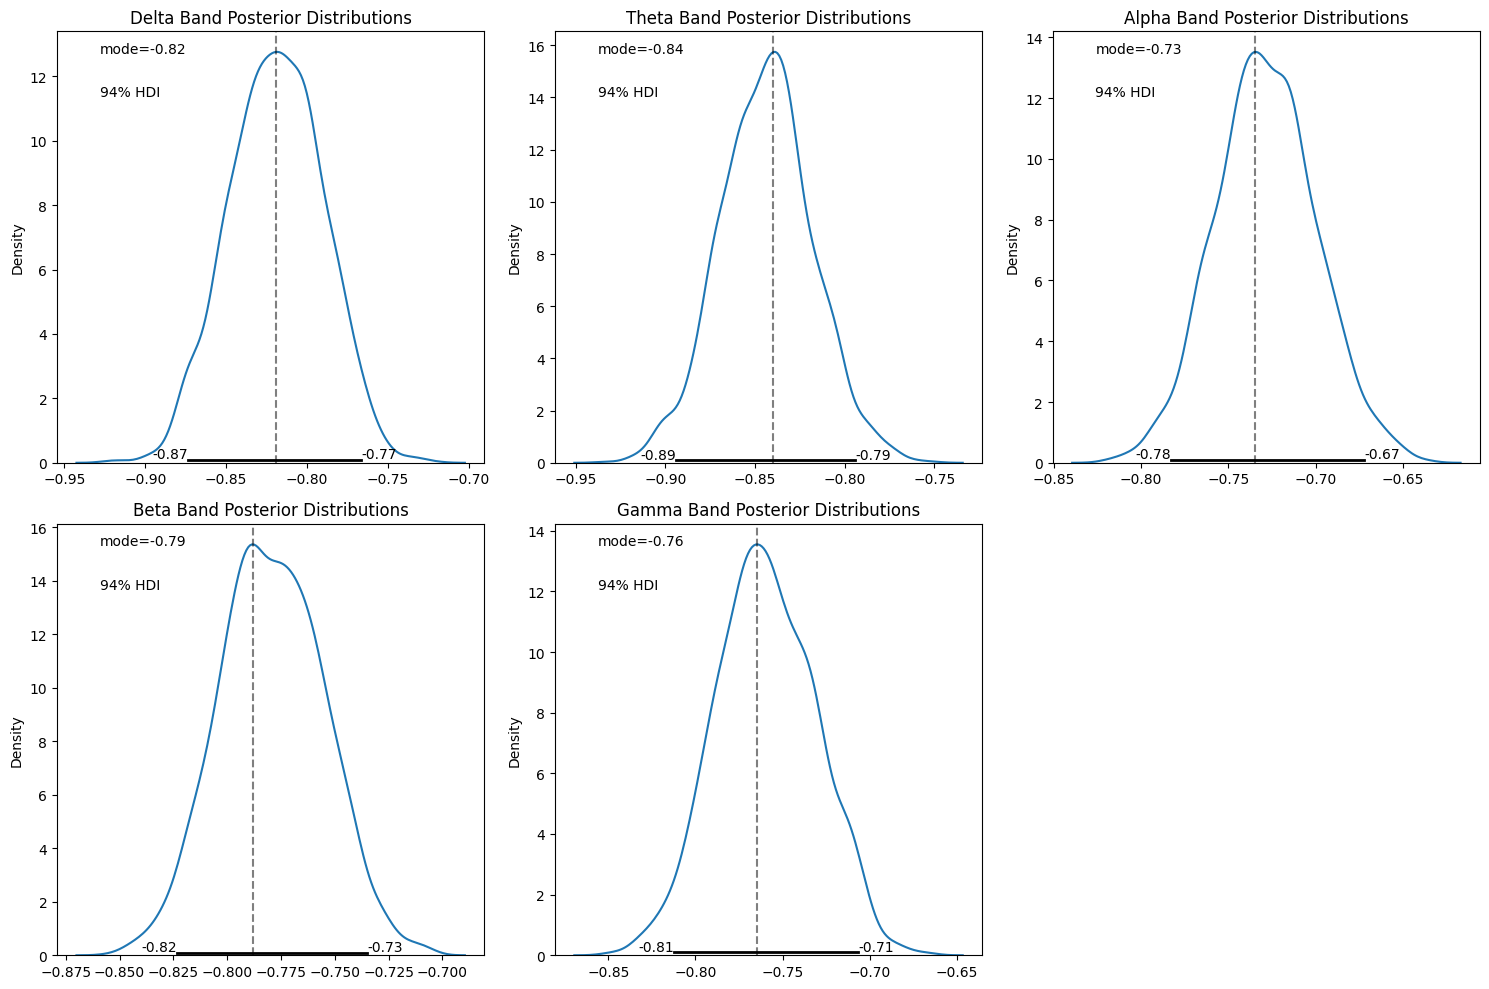

In [8]:
# Function for cluster characteristics plot
def plot_cluster_characteristics(df_sample, features):
    fig, ax = plt.subplots(figsize=(12, 8))

    for marker in sorted(df_sample['Marker'].unique()):
        cluster_data = df_sample[df_sample['Marker'] == marker][features].mean()
        plt.plot(features, cluster_data, marker='o', label=f'State {marker}')

    plt.title('Average PCA Values Across Different States')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function for individual posterior plots
def plot_individual_posteriors(results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, (band, trace) in enumerate(results.items()):
        if i < 5:  # We only have 5 bands
            ax = axes[i]

            # Get samples for state 1
            samples = trace.posterior[f'mu_state1_{band}'].values.flatten()

            # Calculate mode and HDI
            kde = stats.gaussian_kde(samples)
            x_points = np.linspace(min(samples), max(samples), 100)
            y_points = kde(x_points)
            mode_idx = np.argmax(y_points)
            mode = x_points[mode_idx]

            # Calculate HDI
            hdi = np.percentile(samples, [3, 97])  # 94% HDI

            # Plot
            sns.kdeplot(data=samples, ax=ax)

            # Add mode and HDI annotations
            ax.axvline(mode, color='k', linestyle='--', alpha=0.5)
            ax.text(0.1, 0.95, f'mode={mode:.2f}', transform=ax.transAxes)
            ax.text(0.1, 0.85, '94% HDI', transform=ax.transAxes)

            # Add HDI bar
            ax.plot([hdi[0], hdi[1]], [0.1, 0.1], color='black', linewidth=2)
            ax.text(hdi[0], 0.15, f'{hdi[0]:.2f}', ha='right')
            ax.text(hdi[1], 0.15, f'{hdi[1]:.2f}', ha='left')

            ax.set_title(f'{band} Band Posterior Distributions')

    # Remove the empty subplot
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

features = ['Delta_PCA', 'Theta_PCA', 'Alpha_PCA', 'Beta_PCA', 'Gamma_PCA']
plot_cluster_characteristics(df_sample, features)

plot_individual_posteriors(results)